## Q2: Conduct a customer segmentation for the wholesale distributor dataset.

* Student ID: p233340 
* Name: Kwok Tsz Yi
* Course: COM6101 

In [26]:
# import dataset
import pandas as pd
df = pd.read_csv('Q2.csv')
df.head()

,CustID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,online,Shenzhen,12669,9656,7561,214,2674.0,1338
1,2,online,Shenzhen,7057,9810,9568,1762,3293.0,1776
2,3,online,Shenzhen,6353,8808,7684,2405,3516.0,7844
3,4,offline,Shenzhen,13265,1196,4221,6404,507.0,1788
4,5,online,Shenzhen,22615,5410,7198,3915,1777.0,5185


### Exploratory Data Analysis

Size of the dataset:

In [27]:
df.shape

(440, 9)

Data types of the dataset:

In [28]:
df.dtypes

CustID                int64
Channel              object
Region               object
Fresh                object
Milk                  int64
Grocery               int64
Frozen                int64
Detergents_Paper    float64
Delicatessen          int64
dtype: object

Missing values in the dataset:

In [29]:
# find rows with missing values
df.isnull().sum()

CustID              0
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    1
Delicatessen        0
dtype: int64

Handle the only missing value in the dataset: fill in the Detergents_Paper NaN with median value.

In [31]:
median_detergents_paper = df['Detergents_Paper'].median()
df['Detergents_Paper'] = df['Detergents_Paper'].fillna(median_detergents_paper)
df.isnull().sum() # check if the missing values are filled

CustID              0
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

Find the correlation between the features:

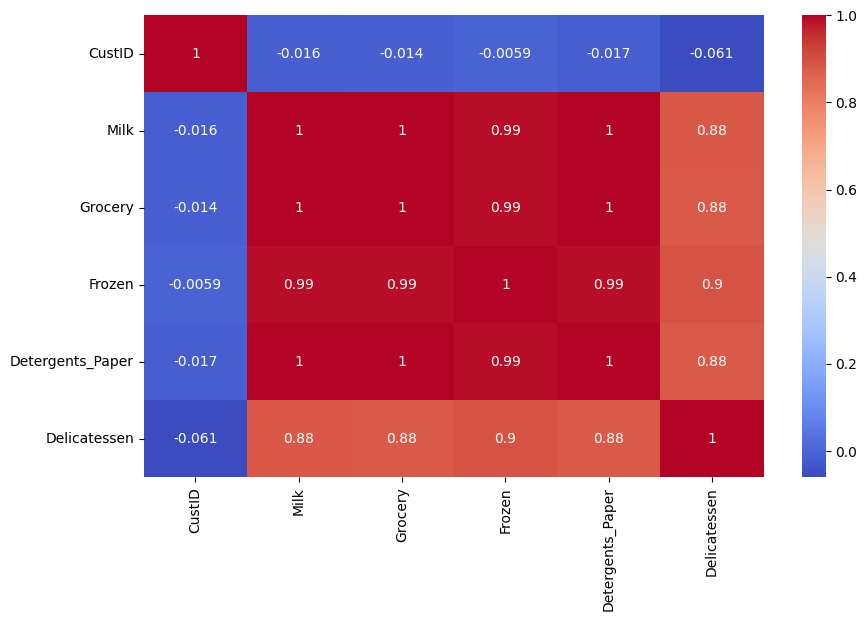

In [43]:
# generate a heatmap to check the correlation between the features
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

As per the heatmap, the highest correlation are between Detergents_Paper and Milk, Grocery and Detegents_Paper, the correlation of them is 1, which means they have a linear positive relationship.

In [41]:
# generate a table group by region and find the mean of each product
df.groupby('Region').mean(numeric_only=True)

,CustID,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Region,,,,,,
Beijing,317.000000,5088.170213,9218.595745,4045.361702,3687.468085,1159.702128
HK,235.000000,5486.415584,7403.077922,3000.337662,2651.116883,1354.896104
Shenzhen,202.613924,35021.085443,156932.091772,5286.132911,13387.240506,1968.667722


In [44]:
# generate a table, group by region, sub-group by channel, and find the mean of each product
df.groupby(['Region', 'Channel']).mean(numeric_only=True)

CustID          Milk        Grocery       Frozen  \
Region   Channel                                                         
Beijing  offline  321.000000   2304.250000    4395.500000  5745.035714   
         online   311.105263   9190.789474   16326.315789  1540.578947   
HK       offline  237.728814   3870.203390    4026.135593  3127.322034   
         online   226.055556  10784.000000   18471.944444  2584.111111   
Shenzhen offline  227.582938  46984.156398  227087.161137  7163.658768   
         online   152.438095  10981.009524   15953.809524  1513.200000   

                  Detergents_Paper  Delicatessen  
Region   Channel                                  
Beijing  offline        482.714286   1105.892857  
         online        8410.263158   1239.000000  
HK       offline        950.525424   1197.152542  
         online        8225.277778   1871.944444  
Shenzhen offline      16615.867299   2039.559242  
         online        6899.238095   1826.209524

In [47]:
# generate a table, group by channel, sub-group by region, and find the mean of each product
df.groupby(['Channel', 'Region']).mean(numeric_only=True)

CustID          Milk        Grocery       Frozen  \
Channel Region                                                           
offline Beijing   321.000000   2304.250000    4395.500000  5745.035714   
        HK        237.728814   3870.203390    4026.135593  3127.322034   
        Shenzhen  227.582938  46984.156398  227087.161137  7163.658768   
online  Beijing   311.105263   9190.789474   16326.315789  1540.578947   
        HK        226.055556  10784.000000   18471.944444  2584.111111   
        Shenzhen  152.438095  10981.009524   15953.809524  1513.200000   

                  Detergents_Paper  Delicatessen  
Channel Region                                    
offline Beijing         482.714286   1105.892857  
        HK              950.525424   1197.152542  
        Shenzhen      16615.867299   2039.559242  
online  Beijing        8410.263158   1239.000000  
        HK             8225.277778   1871.944444  
        Shenzhen       6899.238095   1826.209524

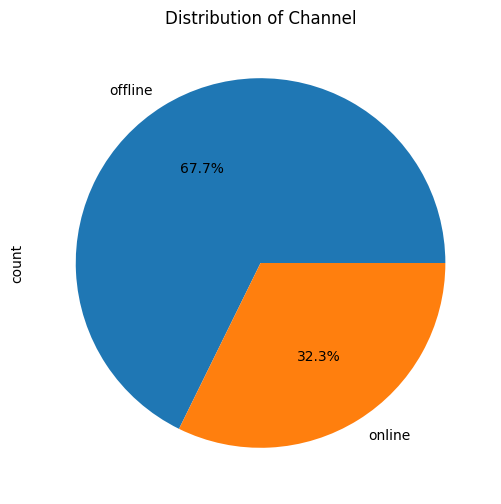

In [48]:
# pie chart for the distribution of the channel
plt.figure(figsize=(10, 6))
df['Channel'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Channel')
plt.show()

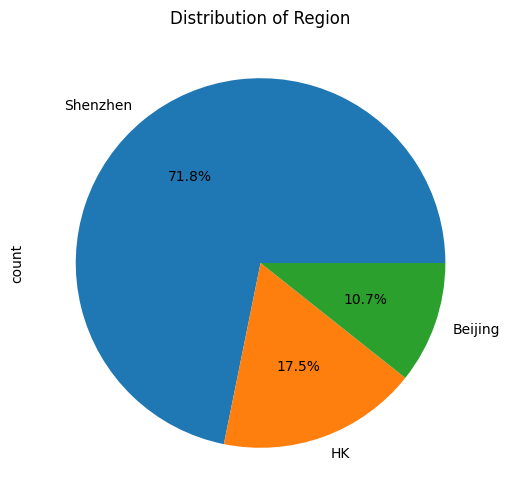

In [49]:
# pie chart for the distribution of the region
plt.figure(figsize=(10, 6))
df['Region'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Region')
plt.show()

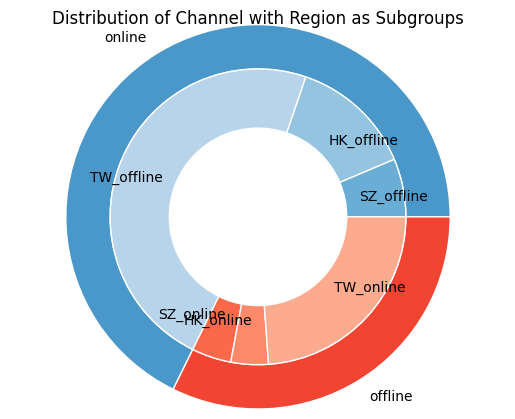

In [68]:
# as per the above example, we can create a donut chart for the distribution of channel, having region as subgroups
# group names are values in the 'Channel' column
group_names = df['Channel'].unique().tolist()
group_size = df['Channel'].value_counts()
subgroup_names = ['SZ_offline', 'HK_offline', 'TW_offline', 'SZ_online', 'HK_online', 'TW_online']
subgroup_size = df.groupby('Channel')['Region'].value_counts().unstack().fillna(0).values.flatten()

# Create colors depending on the number of group names
a, b = [plt.cm.Blues, plt.cm.Reds]

# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')

# second ring (inside), with percentage of each subgroup
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

        
# show it
plt.title('Distribution of Channel with Region as Subgroups')
plt.show()

In [76]:
# use ploty to create a donut chart for the distribution of channel, having region as subgroups
import plotly.graph_objects as go
group_names = df['Channel'].unique().tolist()
group_size = df['Channel'].value_counts()
subgroup_names = ['SZ_offline', 'HK_offline', 'TW_offline', 'SZ_online', 'HK_online', 'TW_online']
subgroup_size = df.groupby('Channel')['Region'].value_counts().unstack().fillna(0).values.flatten()
labels = group_names
values = group_size
sub_labels = subgroup_names
sub_values = subgroup_size
fig = go.Figure()
fig.add_trace(go.Pie(labels=labels, values=values, hole=.3, name='Channel',
                     marker_colors=[a(0.6), b(0.6)]))
fig.add_trace(go.Pie(labels=sub_labels, values=sub_values, hole=.5, name='Region',
                        marker_colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
                )
fig.update_layout(title_text='Distribution of Channel with Region as Subgroups')
# adjust the size of the chart
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.show()